# Imports

In [1]:
from pipeline import loading_pipeline
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import KBinsDiscretizer

from model_training import PyTorchModel, evaluate_regression_model, evaluate_classification_model
import transformers

# Preprocessing

In [2]:
X_train, y_train, X_test, y_test = loading_pipeline()

Number of samples: 8600
Signal Length: 2816
X-Shape: (8100, 1408, 2)
y-Shape: (8100,)
X-Shape: (500, 1408, 2)
y-Shape: (500,)
Augmented X.shape: (40500, 1152, 2)
Augmented y.shape: (40500,)
Trimmed X.shape: (500, 1152, 2)


In [3]:
def filter_labels(X, y, labels_to_keep):
    # Find indices where label is either 0 or 4
    indices_to_keep = np.isin(y, labels_to_keep)
    # Keep only the samples with the desired labels
    X_filtered = X[indices_to_keep]
    y_filtered = y[indices_to_keep]
    return X_filtered, y_filtered

# Specify the labels to keep
labels_to_keep = [0, 4]

# Filter the training and test sets
X_train, y_train = filter_labels(X_train, y_train, labels_to_keep)
X_test, y_test = filter_labels(X_test, y_test, labels_to_keep)

y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Show the shapes of the filtered datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16200, 1152, 2), (16200,), (200, 1152, 2), (200,))

# Transformer

In [4]:
num_classes = len(np.unique(y_train))
print(num_classes)

2


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# # Quantization
# num_bins = 75  # Adjust as needed
# kbin = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
# kbin.fit(X_train.reshape(-1, 1))
# 
# X_train_quantized = kbin.transform(X_train.reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1], -1)
# X_test_quantised = kbin.transform(X_test.reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1], -1)

Using device: cuda:0


In [6]:
class AttentionPool(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Parameter(torch.randn(d_model))

    def forward(self, x):
        attn_weights = F.softmax(torch.matmul(x, self.query), dim=1)
        pooled = torch.matmul(attn_weights.unsqueeze(1), x).squeeze(1)
        return pooled, attn_weights

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_classes, num_layers, seq_len):
        super().__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attention_pool = AttentionPool(d_model)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src):
        # Project input features to d_model dimensions and apply positional encoding
        src = self.input_projection(src) * torch.sqrt(torch.tensor(self.d_model, dtype=src.dtype))
        src += self.positional_encoding[:, :src.size(1), :]
        src = src.permute(1, 0, 2)  # [seq_len, batch_size, features]
        transformer_output = self.transformer_encoder(src)
        transformer_output = transformer_output.permute(1, 0, 2)  # [batch_size, seq_len, features]
        pooled, _ = self.attention_pool(transformer_output)
        output = self.fc(pooled)
        return output

In [7]:
# Initialize the model with the correct input dimensions
input_dim = X_train.shape[2]  # Number of features per timestep in the signal
seq_len = X_train.shape[1]  # Sequence length
d_model = 128  # Size of the feature space to project the inputs
nhead = 4  # Number of attention heads
num_layers = 2  # Number of transformer layers
transformer_model = TransformerModel(input_dim, d_model, nhead, num_classes, num_layers, seq_len)


# Assuming you have defined 'device' (e.g., torch.device("cuda:0"))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

# Wrap the model in the PyTorchModel class
model = PyTorchModel(transformer_model, criterion, optimizer, device)

/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/25], Train Loss: 0.6345, Val Loss: 0.6514
Epoch [2/25], Train Loss: 0.5922, Val Loss: 0.6059
Epoch [3/25], Train Loss: 0.5892, Val Loss: 0.6026
Epoch [4/25], Train Loss: 0.5885, Val Loss: 0.6023
Epoch [5/25], Train Loss: 0.5862, Val Loss: 0.6058
Epoch [6/25], Train Loss: 0.5852, Val Loss: 0.5925
Epoch [7/25], Train Loss: 0.5815, Val Loss: 0.6020
Epoch [8/25], Train Loss: 0.5824, Val Loss: 0.6023
Epoch [9/25], Train Loss: 0.5787, Val Loss: 0.5884
Epoch [10/25], Train Loss: 0.5794, Val Loss: 0.6145
Epoch [11/25], Train Loss: 0.5840, Val Loss: 0.6200
Epoch [12/25], Train Loss: 0.5796, Val Loss: 0.6015
Epoch [13/25], Train Loss: 0.5837, Val Loss: 0.6087
Epoch [14/25], Train Loss: 0.5753, Val Loss: 0.6159
Early stopping triggered
Accuracy: 0.75
Precision: 0.751610305958132
Recall: 0.75
F1-Score: 0.7495993589743588
ROC-AUC: 0.75


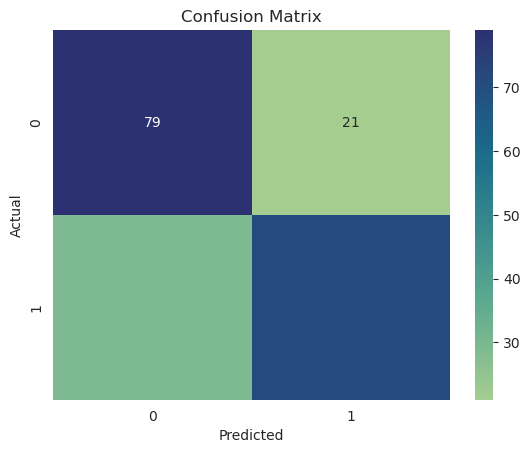


Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       100
           1       0.77      0.71      0.74       100

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200


In [8]:
evaluate_classification_model(model, X_train, y_train, X_test, y_test)

In [9]:
#todo LOOCV based on candidate-id, select all samples from X number of candidates (men and women balanced maybe)
#todo use currently done test set as validation set
#todo integrate validation set performance metrics into training